## USING RESENT9 ARCHITECTURE BASED CNN DEEP LEARNING MODEL


In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
data_dir = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection'
print(os.listdir(data_dir))

['Test', 'Train']


In [3]:
len(os.listdir(data_dir + '/Train'))

4

*FOR NOW, WE ONLY DO A SIMPLE TENSOR TRANSFORM WHILE MAKING AN IMAGE FOLDER OBJECT BECAUSE WE WILL USE THIS TO FIND MEAN AND STANDARD DEVIATIONS FOR IMAGE NORMALISATION*

In [4]:
train_ds = ImageFolder(data_dir + '/Train', tt.ToTensor())

*LET'S TAKE A LOOK AT AN IMAGE TENSOR*

In [5]:
train_ds[0]

(tensor([[[0.1412, 0.1412, 0.1529,  ..., 0.1608, 0.1490, 0.1490],
          [0.1412, 0.1412, 0.1529,  ..., 0.1647, 0.1490, 0.1490],
          [0.1490, 0.1490, 0.1529,  ..., 0.1804, 0.1529, 0.1490],
          ...,
          [0.7059, 0.7059, 0.7059,  ..., 0.0588, 0.0588, 0.0588],
          [0.7059, 0.7059, 0.7059,  ..., 0.0314, 0.0275, 0.0275],
          [0.7059, 0.7059, 0.7059,  ..., 0.0196, 0.0157, 0.0157]],
 
         [[0.0667, 0.0667, 0.0667,  ..., 0.0549, 0.0471, 0.0471],
          [0.0667, 0.0667, 0.0667,  ..., 0.0627, 0.0510, 0.0510],
          [0.0667, 0.0667, 0.0627,  ..., 0.0863, 0.0627, 0.0627],
          ...,
          [0.5608, 0.5608, 0.5608,  ..., 0.5333, 0.5490, 0.5490],
          [0.5608, 0.5608, 0.5608,  ..., 0.5255, 0.5373, 0.5373],
          [0.5608, 0.5608, 0.5608,  ..., 0.5216, 0.5333, 0.5333]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0118, 0.0039, 0.0039],
          [0.0078, 0.0078, 0.0078,  ...,

*LET'S TAKE A LOOK AT SOME CLASSES*

In [6]:
train_ds.classes[0:10]

['angry', 'happy', 'neutral', 'sad']

*CREATING A DATALOADER FOR IMAGE VISUALIZATION AND CALCULATING IMAGE MEAN AND STD DEVIATIONS*

In [7]:
batch_size = 91
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
train_ds[0][0].shape

torch.Size([3, 182, 182])

In [9]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  angry (0)


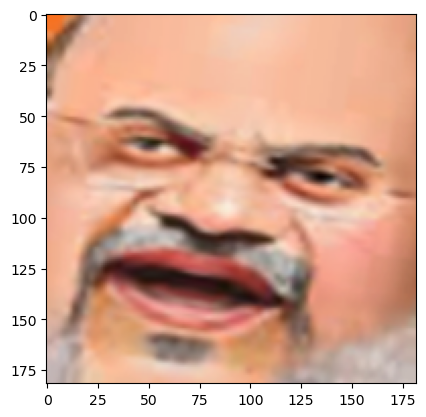

In [10]:
show_example(*train_ds[100])

In [11]:
len(train_ds)

1810

*LET'S DEFINE A HELPER TO FUNCTION TO VISUALIZE A FULL BATCH OF IMAGES*

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(15,20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

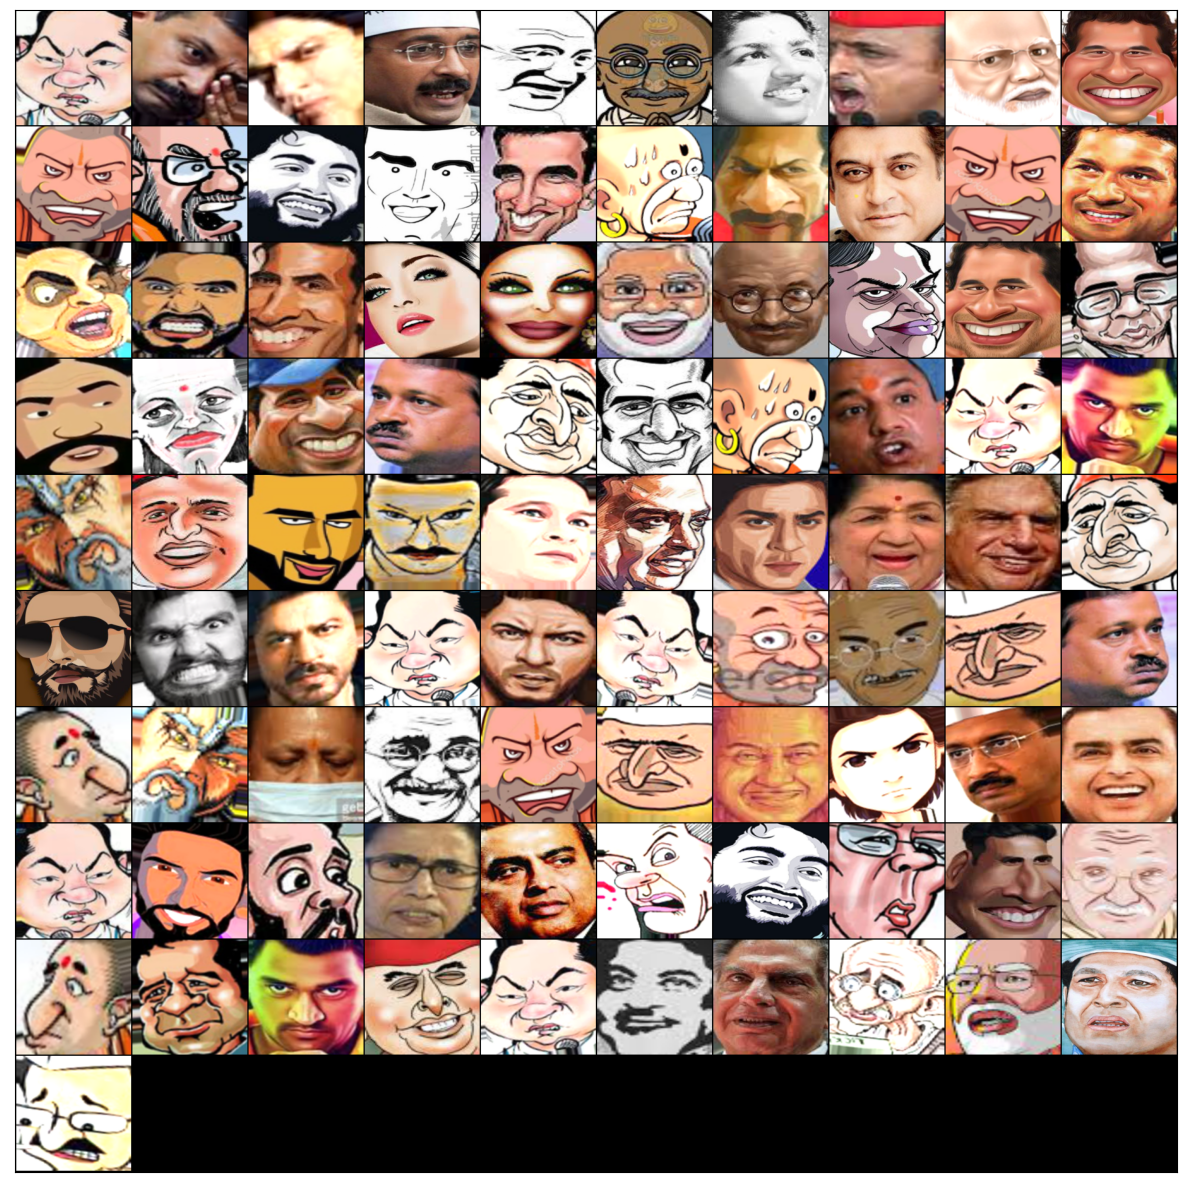

In [13]:
show_batch(train_dl)

In [14]:
def get_mean_std(loader):
  ch_sum, ch_sq_sum, num_batches = 0, 0, 0
  for data,_ in loader:
    ch_sum += torch.mean(data, dim=[0,2,3])
    ch_sq_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
  mean = ch_sum/num_batches
  std = (ch_sq_sum/num_batches - mean**2)**0.5
  return mean, std

## CALCULATING MEAN AND STD DEVIATION OF IMAGES FOR DATA NORMALISATION

In [15]:
mean, std = get_mean_std(train_dl)

In [16]:
mean

tensor([0.6879, 0.5606, 0.4915])

In [17]:
std

tensor([0.2957, 0.2846, 0.2824])

In [18]:
mean_values = tuple(mean.numpy())
std_values = tuple(std.numpy())

## IMPORTING THE TRAINING AND VALIDATION DATASET USING IMAGEFOLDER METHOD OF PYTORCH AND AUGEMENTING & NORMALISING THE DATA.

*LETS MAKE A NEW IMAGEFOLDER OBJECT BUT NOW WE ALSO PERFORM NORMALISATION AND AUGEMENTATION*

In [19]:
stats = (mean_values, std_values)
train_tfms = tt.Compose([tt.RandomCrop(182, padding=4, padding_mode='reflect'), tt.RandomHorizontalFlip(), tt.ToTensor(),tt.Normalize(*stats,inplace=True)])

*FOR AUGEMENTATION, WE ARE USING RandomCrop WHICH BASICALLY CROPS A RANDOM PART OF THE IAMGE ACC TO THE SPECIFIED PARAMS AND ALSO WE ARE DOING A RandomHorizontalFlip OF THE IMAGES*



In [20]:
train_ds1 = ImageFolder(data_dir + '/Train', train_tfms)

In [21]:
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [22]:
valid_ds = ImageFolder(data_dir+'/Test', valid_tfms)

Label:  angry (0)


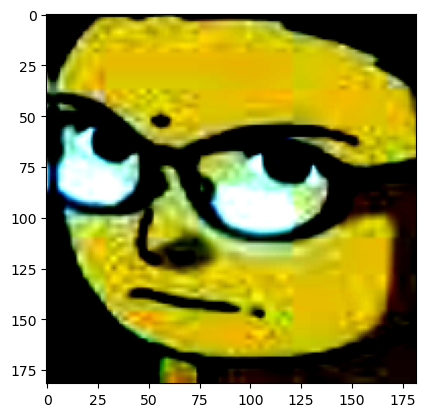

In [23]:
show_example(*train_ds1[0])

*CREATING TRAINING AND VALIDATION DATALOADERS*

## CREATING DATALOADERS TO RETREIVE BATCHES OF IMAGES.

In [24]:
train_dl1 = DataLoader(train_ds1, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [25]:
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [26]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

*THESE dernormalize and show_batch HELPER FUNCTIONS ARE DEFINED TO DISPLAY THE IMAGES AS THEY WERE BEFORE AUGUMENTATION AND NORMALIZATION.*

In [ ]:
show_batch(train_dl1)

In [ ]:
show_batch(valid_dl)

## SHIFTING THE DATALOADERS ON THE GPU

HERE, WE HAVE DEFINED SOME HELPER FUNCTIONS TO SHIFT THE DATALOADERS AND MODELS ON THE GPU TO UTILIZE THE POWER OF GPU.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl1 = DeviceDataLoader(train_dl1, device)

In [ ]:
valid_dl = DeviceDataLoader(valid_dl, device)

## EXTENDING THE nn.Module CLASS FOR REQUIRED FUNCTIONS.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## **DEFINING THE MAIN RESNET9 ARCHITECTURE BASED CNN MODEL.**

# RESNET9

*BELOW IMAGE SHOWS A PROPER CLASSICAL RESNET9 ARCHITECTURE*

**I USED A VERY SIMPLE AND COMPACT FORM OF A RESNET9 ARCHITECTURE.**

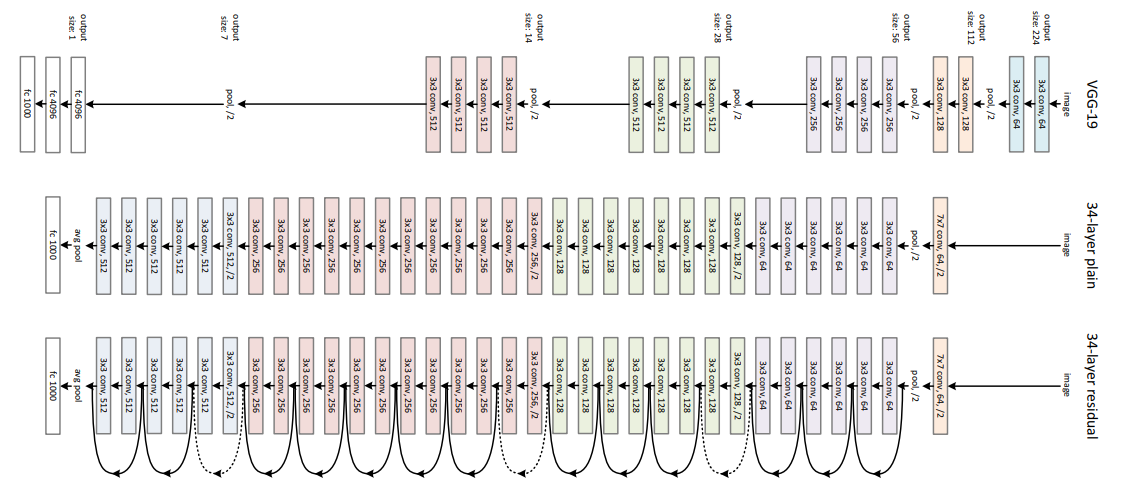

**Residual Block**:

In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.

The approach behind this network is instead of layers learn the underlying mapping, we allow network fit the residual mapping. So, instead of say H(x), initial mapping, let the network fit, F(x) := H(x) – x which gives H(x) := F(x) + x.

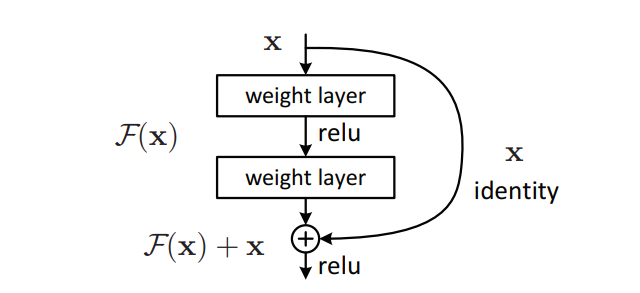

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #100 x 3 x 100 x 100
        self.conv1 = conv_block(in_channels, 64)                                #100 x 64 x 80 x 80
        self.conv2 = conv_block(64, 128, pool=True)                             #100 x 128 x 40 x 40
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))   #100 x 128 x 40 x 40
        
        self.conv3 = conv_block(128, 256, pool=True)                            #100 x 256 x 20 x 20
        self.conv4 = conv_block(256, 512, pool=True)                            #100 x 512 x 10 x 10
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv5 = conv_block(512, 1024, pool=True)                           #100 x 1024 x 5 x 5 
        self.conv6 = conv_block(1024, 2048, pool=True)                          #100 x 2048 x 2 x 2
        self.res3 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))   #100 x 2048 x 2 x 2
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.15),
                                        nn.Linear(2048, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

**CREATING THE MODEL OBJECT AND SHIFTING IT ON THE GPU**

In [ ]:
model = to_device(ResNet9(3, 4), device)
model

In [ ]:

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## TRAINING THE MODEL AND EVALUATING SIMUNTANEOUSLY.

In [ ]:
epochs = 4
max_lr = 0.01
grad_clip = 0.101
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [44]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()  

| ID | GPU | MEM |
------------------
|  0 |  0% | 93% |
|  1 |  0% |  0% |


In [45]:
import torch
torch.cuda.empty_cache()

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl1, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

*THE MODEL TOOK A CONSIDERABLE TIME OF 54MINUTES TO TRAIN.*

In [41]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   12013 MB |   12760 MB |   29190 MB |   17176 MB |\n|       from large pool |   12011 MB |   12759 MB |   29188 MB |   17176 MB |\n|       from small pool |       2 MB |       2 MB |       2 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   12013 MB |   12760 MB |   29190 MB |   17176 MB |\n|       from large pool |   12011 MB |   12759 MB |

# PLOTTING MODEL ACCURACY, LOSS AND LEARNING RATES AGAINST NO OF EPOCHS.

In [42]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

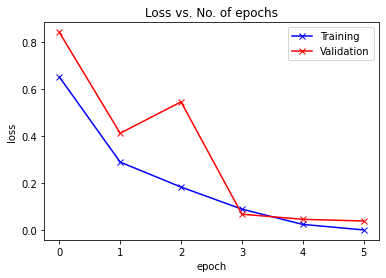

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

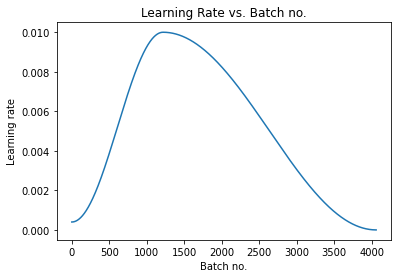

In [ ]:
plot_lrs(history)